# 2 Qubit Grover Search
This is a sample implementation of a trivial 2 Qubit Grover Search on IBM Quantum Experience. Ensure that you already have an IBM Quantum Experience Account to use the cloud quantum computing facilities provided by IBM. 

<em>This notebook assumes that you are already familiar with bra-ket notation and quantum gates. Do refer to Nielsen and Chuang's Quantum Information and Computation textbook if anything should be unclear. Apologies in advance to anyone reading this.</em> (⊃◜⌓◝⊂)

Glossing over key details, the algorithm essentially does a few things:
1. Applies some oracle to mark the solutions
2. Amplifies probabilities to make the solution more obvious
3. Repeat until we can find the solution with ~100% accuracy

### Import Relevant Libraries

In [1]:
# Setting up...
import time

# Import QISKIT
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import register, available_backends, get_backend, execute
from qiskit.tools.visualization import plot_histogram, circuit_drawer

# Latex
from IPython.display import Latex

### Settings
We use the following settings, change accordingly.

In [2]:
# Settings
LOCAL = False
USE_SIMULATOR = False
MAX_CREDIT = 3
SHOTS = 1024
QUBITS = 5    # We only have 5 Qubits and 16 Qubits QC available

In [3]:
# Backends available

print("Local backends: ", available_backends({'local': True}))
 

Local backends:  ['local_clifford_simulator', 'local_unitary_simulator', 'local_statevector_simulator', 'local_qasm_simulator']


### Load Backend
Load the backend based on the Settings given above.

In [4]:
# Load Backend
if LOCAL:
    # Local backends available
    # 'local_statevector_simulator', 'local_clifford_simulator', 'local_qasm_simulator', 'local_unitary_simulator'
    backend = "local_qasm_simulator"

else:
    try:
        import Qconfig
        qx_config = {
            "APIToken": Qconfig.APIToken,
            "url": Qconfig.config['url']
        }

    except Exception as e:
        print(e)
        qx_config = {
            "APIToken": "Insert Token Here",
            "url": "https://quantumexperience.ng.bluemix.net/api"
            }

    # Use simulator
    if not USE_SIMULATOR:
        if QUBITS == 5:
            backend = "ibmqx4"
        elif QUBITS == 16:
            backend = "ibmqx5"
        else:
            print("Only 5 Qubit and 16 Qubit quantum computer is available.")

    else:
        backend = "ibmqx_qasm_simulator"
        
    #Setup API
    register(qx_config['APIToken'], qx_config['url'])
    print("All backends: ", available_backends())

All backends:  ['local_clifford_simulator', 'ibmqx5', 'local_qasm_simulator', 'local_statevector_simulator', 'ibmqx4', 'local_unitary_simulator', 'ibmq_qasm_simulator', 'ibmqx2']


### Setup Quantum Circuit
In our case we only need 2 Qubit Registers and 2 Classical Registers for output

In [5]:
try:
    # bit size 
    N = 2

    # Create a quantum register with 2 qbits
    q = QuantumRegister(N)

    # Create a classical register with 2 bits
    c = ClassicalRegister(N)

    # Create a quantum circuit
    qc = QuantumCircuit(q, c)
    
except Exception as e:
    print('There was an exception. {}'.format(e))

# Circuit / Algo
The current setup we're replicating is found here, from the QISKit tutorial. 

**Note that Hadamard - CNOT/CX - Hadamard combination is equivalent to a CZ gate.**

As there are 2 qubits. we have $ 2^2 = 4$ states for example 00, 01, 10, 11. In this case the answer is 00. How we control the result we want is determined by the S phase gate. More examples can be found in the reference to the link to the tutorial in the References section.
![img](https://camo.githubusercontent.com/a744c526554abdeae9fc8aa1274b56c918167a0d/68747470733a2f2f64616c2e6f626a65637473746f726167652e6f70656e2e736f66746c617965722e636f6d2f76312f415554485f34323236336566633435313834633763613437343235313235383861313934322f636f6465732f636f64652d64396334306632376436376434626637323232303966616133346138666431632e706e67)

# Implementation of the Oracle
The action of the oracle essentially marks solution. So we need something that performs the operation below. 

- x is the index register
- q is the oracle qubit (we observe the change in this state)
- O is some unitary operator defined by it action on the computation basis as seen below
- f(x) is a function of x that flips q

The formulation of the oracle is essentially the formula below. 
$$ \left| x \right\rangle \left| q \right\rangle \xrightarrow{O} \left| x \right\rangle \left| q \oplus f(x) \right\rangle $$


A general idea as to how this work is that we can first prepare the input state |x> |0> and check if the oracle qubit in this case |0> has flipped to |1>. If it is not a solution there would be no change. We can apply a Hadamard transform to obtain the following action of the oracle. Note: If x is not a solution the state is unchnged. If x is a solution |0> and |1> is interchanged.

$$\left| x \right\rangle (\frac{\left| 0 \right\rangle - \left| 1 \right\rangle}{\sqrt{2}}) \xrightarrow{O} (-1)^{f(x)} \left| x \right\rangle (\frac{\left| 0 \right\rangle - \left| 1 \right\rangle}{\sqrt{2}})
 $$ 

Simplifying the notation further we can essentially treat the operation as below.
$$ \left| x \right\rangle \xrightarrow{O} (-1)^{f(x)} \left| x \right\rangle $$



## Code

In [6]:
######################
#    	ORACLE		 #
######################
try:
    # Apply H to all qubits to superpose
    for i in range(N):
        qc.h(q[i])

    # Apply S (Clifford phase gate) to all qubits
    for i in range(N):
        qc.s(q[i])

    # Apply CZ, note that this is equivalent to 
    # ---o---
    #    |
    # -H-X-H-
    qc.cz(q[0], q[1])

    # Reapply in reverse
    for i in range(N):
        qc.s(q[i])

except Exception as e:
    print('There was an exception. {}'.format(e))

# Implementation of Inversion About Mean
A key step of the Grover's Search algorithm is to amplify the probability. This step is known as inverting about the mean. This step essentially performs these key operations:

### Overview
1. Apply H gate to all qubits
2. Apply a conditional phase shift 
3. Apply H gate to all qubits again

In [7]:
######################
#    INV ABOUT MEAN	 #
######################
try:
    # Apply H to all bits
    for i in range(N):
        qc.h(q[i])
        
    # Apply X to all bits
    for i in range(N):
        qc.x(q[i])

    # Apply CZ, note that this is equivalent to 
    # ---o---
    #    |
    # -H-X-H-
    qc.cz(q[0], q[1])

    # Apply X to all bits
    for i in range(N):
        qc.x(q[i])

    # Apply H to all bits				
    for i in range(N):
        qc.h(q[i])

except Exception as e:
    print('There was an exception. {}'.format(e))

# Measurement and Execution

In [8]:
try:
    # Add a measure gate to see the state
    qc.measure(q, c)

    # See a list of available local simulators
    # print("Local Backends: ", available_backends({'local': True}))

    # Compile and execute
    if LOCAL:
        job_exp = execute(qc, backend)
    else:
        job_exp = execute(qc, backend, shots = SHOTS, max_credits = MAX_CREDIT)

        
    count = 0
    while not job_exp.done:
        # check job status every 10 seconds
        time.sleep(10)
        
        # Print every minute
        count += 1
        if count % 6 == 0:
            print("Waiting for server...")
        
    result = job_exp.result()

    # Display result
    print("Results: ", result)
    print(result.get_data())

except Exception as e:
    print('There was an exception. {}'.format(e))    

Waiting for server...
Waiting for server...
Waiting for server...
Waiting for server...
Waiting for server...
Results:  COMPLETED
{'time': 20.90039300918579, 'counts': {'00': 952, '01': 42, '10': 23, '11': 7}, 'date': '2018-06-14T02:35:22.214Z'}


# Plot Results

## Histogram
Counts for measurement obtained

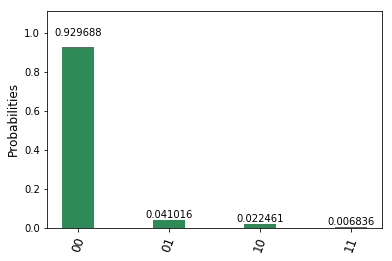

In [9]:
plot_histogram(result.get_counts(qc))

# Final Notes
After applying hadamard to all the qubits initially. We apply the oracle and the inversion about the mean, this is known as the Grover's iteration. We have to apply Grover's iteration $O( \sqrt{N} )$ times to get the solution. In this case since we only have 2 qubits applying Grover's iteration ~1 time is sufficient to obtain the desired result.

# References
1. Nielsen and Chuang's Quantum Computation and Information

2. https://github.com/QISKit/ibmqx-user-guides/blob/master/rst/full-user-guide/004-Quantum_Algorithms/070-Grover's_Algorithm.rst

# Gate Used
### Single Gate
- Hadamard,
$ H = \frac{1}{\sqrt{2}}\bigl(\begin{matrix}1 & 1 \\ 1 & -1 \end{matrix}\bigr) $

- Pauli-X,
$ X = \bigl(\begin{matrix}0 & 1 \\ 1 & 0 \end{matrix}\bigr) $

- Pauli-Z,
$ Z = \bigl(\begin{matrix}1 & 0 \\ 0 & -1 \end{matrix}\bigr) $

- S, phase gate,
$ S = \bigl(\begin{matrix}1 & 0 \\ 0 & i \end{matrix}\bigr) $

### Conditional
- CNOT / CX, 
$ CNOT = \begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{bmatrix} $

- CZ, 
$ CZ = \begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \end{bmatrix} $